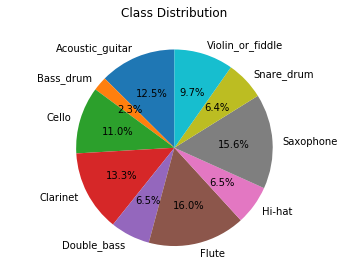

In [16]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from tensorflow.keras.layers import Dropout, Dense, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
from tensorflow.keras import backend
from tensorflow.python.framework import ops
ops.reset_default_graph()



class Config():
    def __init__(self, mode='conv', nfilt = 26, nfeat = 13, nfft = 512, rate = 16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)

def build_rand_feat():
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label == rand_class].index)
        rate, wav = wavfile.read('Clean/'+file)
        label = df.at[file, 'label']
        
        rand_index = np.random.randint(0, wav.shape[0] - config.step) 
        sample = wav[rand_index:rand_index+config.step]
        
        X_sample = mfcc(sample, rate, numcep = config.nfeat, nfilt = config.nfilt, nfft = config.nfft).T
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        
        X.append(X_sample if config.mode == 'conv' else X_sample.T)
        y.append(classes.index(label))
        
    X, y = np.array(X), np.array(y)
    X = (X - _min)/ (_max - _min)
    if config.mode == 'time' :
        X = X.reshape(X.shape[0],X.shape[1], X.shape[2])
        
    y = to_categorical(y, num_classes =10)
    return X, y


def get_recurrent_model():
    model = Sequential()
    model.add(LSTM(128, return_sequence = True, input_shape = input_shape))
    model.add(LSTM(128, return_sequence = True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation = 'relu')))
    model.add(TimeDistributed(Dense(32, activation = 'relu')))
    model.add(TimeDistributed(Dense(16, activation = 'relu')))
    model.add(TimeDistributed(Dense(8, activation = 'relu')))
    model.add(Flatten())
    model.add(Dense(10, activation = 'softmax')) #last layer
    
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer ='adam', metrics = ['acc'])
    return model


df = pd.read_csv('instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

n_samples = 2 * int(df['length'].sum()/ 0.1)
prob_dist = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index, p = prob_dist)



fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

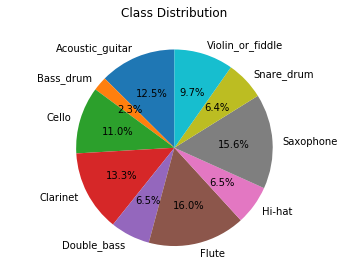

In [19]:
df = pd.read_csv('instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()





def get_recurrent_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences = True, input_shape = input_shape))
    model.add(LSTM(128, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation = 'relu')))
    model.add(TimeDistributed(Dense(32, activation = 'relu')))
    model.add(TimeDistributed(Dense(16, activation = 'relu')))
    model.add(TimeDistributed(Dense(8, activation = 'relu')))
    model.add(Flatten())
    model.add(Dense(10, activation = 'softmax')) #last layer
    
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer ='adam', metrics = ['acc'])
    return model

In [20]:
config = Config(mode = 'time')
if config.mode == 'time' :
    X,y = build_rand_feat()
    y_flat = np.argmax(y, axis = 1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()

100%|██████████| 26410/26410 [01:27<00:00, 303.16it/s]


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9, 128)            72704     
_________________________________________________________________
lstm_1 (LSTM)                (None, 9, 128)            131584    
_________________________________________________________________
dropout (Dropout)            (None, 9, 128)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 9, 64)             8256      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 32)             2080      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 16)             528       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 8)             

In [ ]:
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

model.fit(X, y, epochs = 10, batch_size =32, shuffle = True, class_weight = class_weight )

Train on 26410 samples
Epoch 1/10


10528/26410 [==========>...................] - ETA: 1:41:13 - loss: 2.2997 - acc: 0.12 - ETA: 50:55 - loss: 2.3014 - acc: 0.0781 - ETA: 25:38 - loss: 2.3010 - acc: 0.09 - ETA: 17:13 - loss: 2.2995 - acc: 0.08 - ETA: 13:00 - loss: 2.2970 - acc: 0.08 - ETA: 10:28 - loss: 2.2934 - acc: 0.09 - ETA: 8:47 - loss: 2.2879 - acc: 0.0938 - ETA: 7:35 - loss: 2.2828 - acc: 0.100 - ETA: 6:41 - loss: 2.2792 - acc: 0.107 - ETA: 5:58 - loss: 2.2731 - acc: 0.116 - ETA: 5:25 - loss: 2.2697 - acc: 0.120 - ETA: 4:57 - loss: 2.2663 - acc: 0.122 - ETA: 4:34 - loss: 2.2566 - acc: 0.126 - ETA: 4:15 - loss: 2.2571 - acc: 0.126 - ETA: 3:58 - loss: 2.2545 - acc: 0.136 - ETA: 3:44 - loss: 2.2583 - acc: 0.133 - ETA: 3:31 - loss: 2.2524 - acc: 0.135 - ETA: 3:20 - loss: 2.2471 - acc: 0.139 - ETA: 3:10 - loss: 2.2442 - acc: 0.137 - ETA: 3:01 - loss: 2.2405 - acc: 0.138 - ETA: 2:53 - loss: 2.2333 - acc: 0.143 - ETA: 2:45 - loss: 2.2302 - acc: 0.145 - ETA: 2:39 - loss: 2.2319 - acc: 0.145 - ETA: 2:33 - loss: 2.2351 - a

21568/26410 [=======================>......] - ETA: 32s - loss: 2.0362 - acc: 0.21 - ETA: 32s - loss: 2.0357 - acc: 0.21 - ETA: 31s - loss: 2.0334 - acc: 0.21 - ETA: 31s - loss: 2.0324 - acc: 0.21 - ETA: 31s - loss: 2.0313 - acc: 0.21 - ETA: 31s - loss: 2.0302 - acc: 0.21 - ETA: 30s - loss: 2.0285 - acc: 0.21 - ETA: 30s - loss: 2.0273 - acc: 0.21 - ETA: 30s - loss: 2.0272 - acc: 0.21 - ETA: 30s - loss: 2.0263 - acc: 0.21 - ETA: 30s - loss: 2.0252 - acc: 0.21 - ETA: 29s - loss: 2.0240 - acc: 0.21 - ETA: 29s - loss: 2.0224 - acc: 0.22 - ETA: 29s - loss: 2.0216 - acc: 0.22 - ETA: 29s - loss: 2.0209 - acc: 0.22 - ETA: 29s - loss: 2.0209 - acc: 0.22 - ETA: 29s - loss: 2.0207 - acc: 0.22 - ETA: 29s - loss: 2.0208 - acc: 0.22 - ETA: 29s - loss: 2.0204 - acc: 0.22 - ETA: 28s - loss: 2.0200 - acc: 0.22 - ETA: 28s - loss: 2.0195 - acc: 0.22 - ETA: 28s - loss: 2.0187 - acc: 0.22 - ETA: 28s - loss: 2.0186 - acc: 0.22 - ETA: 28s - loss: 2.0164 - acc: 0.22 - ETA: 28s - loss: 2.0146 - acc: 0.22 - ETA

26410/26410 [==============================] - ETA: 7s - loss: 1.8112 - acc: 0.313 - ETA: 7s - loss: 1.8104 - acc: 0.313 - ETA: 7s - loss: 1.8089 - acc: 0.314 - ETA: 7s - loss: 1.8085 - acc: 0.314 - ETA: 7s - loss: 1.8067 - acc: 0.315 - ETA: 7s - loss: 1.8060 - acc: 0.315 - ETA: 7s - loss: 1.8051 - acc: 0.315 - ETA: 7s - loss: 1.8040 - acc: 0.316 - ETA: 7s - loss: 1.8024 - acc: 0.317 - ETA: 7s - loss: 1.8022 - acc: 0.317 - ETA: 6s - loss: 1.8010 - acc: 0.317 - ETA: 6s - loss: 1.8002 - acc: 0.318 - ETA: 6s - loss: 1.7985 - acc: 0.318 - ETA: 6s - loss: 1.7978 - acc: 0.318 - ETA: 6s - loss: 1.7968 - acc: 0.319 - ETA: 6s - loss: 1.7954 - acc: 0.319 - ETA: 6s - loss: 1.7939 - acc: 0.320 - ETA: 6s - loss: 1.7922 - acc: 0.321 - ETA: 6s - loss: 1.7910 - acc: 0.321 - ETA: 5s - loss: 1.7898 - acc: 0.321 - ETA: 5s - loss: 1.7881 - acc: 0.322 - ETA: 5s - loss: 1.7871 - acc: 0.322 - ETA: 5s - loss: 1.7865 - acc: 0.323 - ETA: 5s - loss: 1.7849 - acc: 0.324 - ETA: 5s - loss: 1.7839 - acc: 0.324 - ETA

11200/26410 [===========>..................] - ETA: 47s - loss: 1.7756 - acc: 0.56 - ETA: 48s - loss: 1.6898 - acc: 0.51 - ETA: 50s - loss: 1.6202 - acc: 0.48 - ETA: 51s - loss: 1.5965 - acc: 0.46 - ETA: 51s - loss: 1.5396 - acc: 0.46 - ETA: 51s - loss: 1.5394 - acc: 0.45 - ETA: 52s - loss: 1.4935 - acc: 0.47 - ETA: 52s - loss: 1.5056 - acc: 0.48 - ETA: 52s - loss: 1.4901 - acc: 0.48 - ETA: 51s - loss: 1.4675 - acc: 0.49 - ETA: 50s - loss: 1.4427 - acc: 0.48 - ETA: 50s - loss: 1.4475 - acc: 0.48 - ETA: 49s - loss: 1.4318 - acc: 0.48 - ETA: 49s - loss: 1.4307 - acc: 0.48 - ETA: 48s - loss: 1.4274 - acc: 0.48 - ETA: 48s - loss: 1.4150 - acc: 0.48 - ETA: 48s - loss: 1.4009 - acc: 0.48 - ETA: 47s - loss: 1.3976 - acc: 0.48 - ETA: 46s - loss: 1.3757 - acc: 0.49 - ETA: 44s - loss: 1.3463 - acc: 0.50 - ETA: 44s - loss: 1.3491 - acc: 0.50 - ETA: 44s - loss: 1.3483 - acc: 0.50 - ETA: 44s - loss: 1.3665 - acc: 0.49 - ETA: 45s - loss: 1.3641 - acc: 0.49 - ETA: 45s - loss: 1.3539 - acc: 0.50 - ETA

23712/26410 [=========================>....] - ETA: 20s - loss: 1.2040 - acc: 0.57 - ETA: 20s - loss: 1.2028 - acc: 0.57 - ETA: 20s - loss: 1.2027 - acc: 0.57 - ETA: 19s - loss: 1.2032 - acc: 0.57 - ETA: 19s - loss: 1.2033 - acc: 0.57 - ETA: 19s - loss: 1.2024 - acc: 0.57 - ETA: 19s - loss: 1.2030 - acc: 0.57 - ETA: 19s - loss: 1.2032 - acc: 0.57 - ETA: 19s - loss: 1.2036 - acc: 0.57 - ETA: 19s - loss: 1.2024 - acc: 0.57 - ETA: 19s - loss: 1.2012 - acc: 0.57 - ETA: 19s - loss: 1.2013 - acc: 0.57 - ETA: 19s - loss: 1.2012 - acc: 0.57 - ETA: 19s - loss: 1.2011 - acc: 0.57 - ETA: 19s - loss: 1.2015 - acc: 0.57 - ETA: 19s - loss: 1.2003 - acc: 0.57 - ETA: 19s - loss: 1.1992 - acc: 0.57 - ETA: 19s - loss: 1.1987 - acc: 0.57 - ETA: 19s - loss: 1.1985 - acc: 0.57 - ETA: 19s - loss: 1.1986 - acc: 0.57 - ETA: 19s - loss: 1.1990 - acc: 0.57 - ETA: 19s - loss: 1.1985 - acc: 0.57 - ETA: 19s - loss: 1.1979 - acc: 0.57 - ETA: 19s - loss: 1.1974 - acc: 0.57 - ETA: 19s - loss: 1.1970 - acc: 0.57 - ETA

26410/26410 [==============================] - ETA: 3s - loss: 1.1277 - acc: 0.598 - ETA: 3s - loss: 1.1273 - acc: 0.598 - ETA: 3s - loss: 1.1274 - acc: 0.597 - ETA: 3s - loss: 1.1266 - acc: 0.598 - ETA: 3s - loss: 1.1259 - acc: 0.598 - ETA: 3s - loss: 1.1251 - acc: 0.598 - ETA: 2s - loss: 1.1250 - acc: 0.598 - ETA: 2s - loss: 1.1244 - acc: 0.599 - ETA: 2s - loss: 1.1239 - acc: 0.599 - ETA: 2s - loss: 1.1244 - acc: 0.598 - ETA: 2s - loss: 1.1243 - acc: 0.598 - ETA: 2s - loss: 1.1246 - acc: 0.599 - ETA: 2s - loss: 1.1242 - acc: 0.599 - ETA: 2s - loss: 1.1244 - acc: 0.599 - ETA: 2s - loss: 1.1243 - acc: 0.599 - ETA: 2s - loss: 1.1245 - acc: 0.599 - ETA: 2s - loss: 1.1246 - acc: 0.599 - ETA: 2s - loss: 1.1246 - acc: 0.599 - ETA: 2s - loss: 1.1246 - acc: 0.599 - ETA: 2s - loss: 1.1251 - acc: 0.599 - ETA: 2s - loss: 1.1249 - acc: 0.599 - ETA: 2s - loss: 1.1244 - acc: 0.599 - ETA: 2s - loss: 1.1240 - acc: 0.599 - ETA: 2s - loss: 1.1239 - acc: 0.599 - ETA: 2s - loss: 1.1241 - acc: 0.599 - ETA

12576/26410 [=============>................] - ETA: 37s - loss: 1.0870 - acc: 0.65 - ETA: 34s - loss: 1.0806 - acc: 0.63 - ETA: 33s - loss: 1.0609 - acc: 0.61 - ETA: 33s - loss: 1.0371 - acc: 0.62 - ETA: 33s - loss: 1.0400 - acc: 0.62 - ETA: 32s - loss: 1.0355 - acc: 0.63 - ETA: 32s - loss: 1.0695 - acc: 0.61 - ETA: 32s - loss: 1.0630 - acc: 0.62 - ETA: 32s - loss: 1.0365 - acc: 0.63 - ETA: 32s - loss: 1.0241 - acc: 0.62 - ETA: 31s - loss: 1.0166 - acc: 0.63 - ETA: 31s - loss: 1.0166 - acc: 0.62 - ETA: 31s - loss: 1.0140 - acc: 0.62 - ETA: 31s - loss: 0.9982 - acc: 0.63 - ETA: 31s - loss: 1.0120 - acc: 0.62 - ETA: 31s - loss: 1.0135 - acc: 0.62 - ETA: 30s - loss: 0.9976 - acc: 0.63 - ETA: 30s - loss: 0.9868 - acc: 0.64 - ETA: 30s - loss: 0.9699 - acc: 0.64 - ETA: 30s - loss: 0.9654 - acc: 0.64 - ETA: 30s - loss: 0.9613 - acc: 0.65 - ETA: 30s - loss: 0.9638 - acc: 0.65 - ETA: 30s - loss: 0.9624 - acc: 0.65 - ETA: 30s - loss: 0.9706 - acc: 0.65 - ETA: 30s - loss: 0.9706 - acc: 0.65 - ETA

25216/26410 [===========================>..] - ETA: 17s - loss: 0.9165 - acc: 0.67 - ETA: 17s - loss: 0.9151 - acc: 0.67 - ETA: 17s - loss: 0.9142 - acc: 0.67 - ETA: 17s - loss: 0.9141 - acc: 0.67 - ETA: 17s - loss: 0.9132 - acc: 0.67 - ETA: 17s - loss: 0.9123 - acc: 0.67 - ETA: 17s - loss: 0.9123 - acc: 0.67 - ETA: 17s - loss: 0.9128 - acc: 0.67 - ETA: 17s - loss: 0.9116 - acc: 0.67 - ETA: 16s - loss: 0.9111 - acc: 0.67 - ETA: 16s - loss: 0.9109 - acc: 0.67 - ETA: 16s - loss: 0.9104 - acc: 0.67 - ETA: 16s - loss: 0.9102 - acc: 0.67 - ETA: 16s - loss: 0.9091 - acc: 0.67 - ETA: 16s - loss: 0.9094 - acc: 0.67 - ETA: 16s - loss: 0.9084 - acc: 0.67 - ETA: 16s - loss: 0.9082 - acc: 0.67 - ETA: 16s - loss: 0.9076 - acc: 0.67 - ETA: 16s - loss: 0.9065 - acc: 0.67 - ETA: 16s - loss: 0.9059 - acc: 0.68 - ETA: 15s - loss: 0.9054 - acc: 0.68 - ETA: 15s - loss: 0.9064 - acc: 0.67 - ETA: 15s - loss: 0.9080 - acc: 0.67 - ETA: 15s - loss: 0.9085 - acc: 0.67 - ETA: 15s - loss: 0.9081 - acc: 0.67 - ETA

26410/26410 [==============================] - ETA: 1s - loss: 0.8773 - acc: 0.691 - ETA: 1s - loss: 0.8775 - acc: 0.691 - ETA: 1s - loss: 0.8774 - acc: 0.691 - ETA: 1s - loss: 0.8770 - acc: 0.691 - ETA: 1s - loss: 0.8766 - acc: 0.691 - ETA: 1s - loss: 0.8767 - acc: 0.691 - ETA: 0s - loss: 0.8756 - acc: 0.691 - ETA: 0s - loss: 0.8756 - acc: 0.691 - ETA: 0s - loss: 0.8749 - acc: 0.691 - ETA: 0s - loss: 0.8748 - acc: 0.691 - ETA: 0s - loss: 0.8745 - acc: 0.691 - ETA: 0s - loss: 0.8743 - acc: 0.691 - ETA: 0s - loss: 0.8739 - acc: 0.691 - ETA: 0s - loss: 0.8737 - acc: 0.691 - ETA: 0s - loss: 0.8739 - acc: 0.691 - ETA: 0s - loss: 0.8737 - acc: 0.691 - ETA: 0s - loss: 0.8739 - acc: 0.692 - ETA: 0s - loss: 0.8742 - acc: 0.691 - 34s 1ms/sample - loss: 0.8741 - acc: 0.6920
Epoch 4/10


12736/26410 [=============>................] - ETA: 32s - loss: 0.8019 - acc: 0.68 - ETA: 32s - loss: 0.9291 - acc: 0.65 - ETA: 32s - loss: 0.8888 - acc: 0.68 - ETA: 32s - loss: 0.8921 - acc: 0.69 - ETA: 32s - loss: 0.8537 - acc: 0.70 - ETA: 32s - loss: 0.8666 - acc: 0.69 - ETA: 32s - loss: 0.8667 - acc: 0.69 - ETA: 31s - loss: 0.8475 - acc: 0.69 - ETA: 31s - loss: 0.8701 - acc: 0.68 - ETA: 31s - loss: 0.8590 - acc: 0.68 - ETA: 31s - loss: 0.8357 - acc: 0.70 - ETA: 31s - loss: 0.8543 - acc: 0.69 - ETA: 31s - loss: 0.8424 - acc: 0.70 - ETA: 31s - loss: 0.8586 - acc: 0.69 - ETA: 31s - loss: 0.8569 - acc: 0.69 - ETA: 31s - loss: 0.8647 - acc: 0.69 - ETA: 30s - loss: 0.8679 - acc: 0.69 - ETA: 30s - loss: 0.8756 - acc: 0.69 - ETA: 30s - loss: 0.8694 - acc: 0.68 - ETA: 30s - loss: 0.8682 - acc: 0.68 - ETA: 30s - loss: 0.8663 - acc: 0.68 - ETA: 30s - loss: 0.8617 - acc: 0.68 - ETA: 30s - loss: 0.8618 - acc: 0.68 - ETA: 30s - loss: 0.8599 - acc: 0.68 - ETA: 30s - loss: 0.8565 - acc: 0.68 - ETA

25760/26410 [============================>.] - ETA: 16s - loss: 0.7658 - acc: 0.72 - ETA: 16s - loss: 0.7642 - acc: 0.73 - ETA: 16s - loss: 0.7620 - acc: 0.73 - ETA: 16s - loss: 0.7618 - acc: 0.73 - ETA: 16s - loss: 0.7624 - acc: 0.73 - ETA: 16s - loss: 0.7628 - acc: 0.73 - ETA: 16s - loss: 0.7619 - acc: 0.73 - ETA: 15s - loss: 0.7624 - acc: 0.73 - ETA: 15s - loss: 0.7616 - acc: 0.73 - ETA: 15s - loss: 0.7618 - acc: 0.73 - ETA: 15s - loss: 0.7620 - acc: 0.73 - ETA: 15s - loss: 0.7615 - acc: 0.73 - ETA: 15s - loss: 0.7613 - acc: 0.73 - ETA: 15s - loss: 0.7611 - acc: 0.73 - ETA: 15s - loss: 0.7604 - acc: 0.73 - ETA: 15s - loss: 0.7606 - acc: 0.73 - ETA: 15s - loss: 0.7606 - acc: 0.73 - ETA: 15s - loss: 0.7610 - acc: 0.73 - ETA: 15s - loss: 0.7607 - acc: 0.73 - ETA: 14s - loss: 0.7611 - acc: 0.73 - ETA: 14s - loss: 0.7609 - acc: 0.73 - ETA: 14s - loss: 0.7617 - acc: 0.72 - ETA: 14s - loss: 0.7617 - acc: 0.72 - ETA: 14s - loss: 0.7610 - acc: 0.73 - ETA: 14s - loss: 0.7616 - acc: 0.72 - ETA

26410/26410 [==============================] - ETA: 0s - loss: 0.7230 - acc: 0.745 - ETA: 0s - loss: 0.7228 - acc: 0.745 - ETA: 0s - loss: 0.7225 - acc: 0.745 - ETA: 0s - loss: 0.7220 - acc: 0.746 - ETA: 0s - loss: 0.7214 - acc: 0.746 - ETA: 0s - loss: 0.7216 - acc: 0.746 - ETA: 0s - loss: 0.7214 - acc: 0.746 - ETA: 0s - loss: 0.7211 - acc: 0.746 - ETA: 0s - loss: 0.7215 - acc: 0.746 - ETA: 0s - loss: 0.7213 - acc: 0.746 - 31s 1ms/sample - loss: 0.7212 - acc: 0.7461
Epoch 5/10


12480/26410 [=============>................] - ETA: 35s - loss: 0.9805 - acc: 0.65 - ETA: 31s - loss: 0.8419 - acc: 0.69 - ETA: 30s - loss: 0.8633 - acc: 0.70 - ETA: 29s - loss: 0.7369 - acc: 0.72 - ETA: 29s - loss: 0.6722 - acc: 0.76 - ETA: 29s - loss: 0.6663 - acc: 0.75 - ETA: 28s - loss: 0.7062 - acc: 0.73 - ETA: 28s - loss: 0.6876 - acc: 0.74 - ETA: 28s - loss: 0.6857 - acc: 0.74 - ETA: 28s - loss: 0.6761 - acc: 0.75 - ETA: 28s - loss: 0.6846 - acc: 0.75 - ETA: 28s - loss: 0.6912 - acc: 0.74 - ETA: 28s - loss: 0.6786 - acc: 0.75 - ETA: 28s - loss: 0.6830 - acc: 0.74 - ETA: 28s - loss: 0.6727 - acc: 0.75 - ETA: 28s - loss: 0.6883 - acc: 0.75 - ETA: 28s - loss: 0.6934 - acc: 0.75 - ETA: 28s - loss: 0.6807 - acc: 0.75 - ETA: 27s - loss: 0.6826 - acc: 0.75 - ETA: 27s - loss: 0.6723 - acc: 0.76 - ETA: 27s - loss: 0.6728 - acc: 0.75 - ETA: 27s - loss: 0.6700 - acc: 0.76 - ETA: 27s - loss: 0.6819 - acc: 0.75 - ETA: 27s - loss: 0.6749 - acc: 0.76 - ETA: 27s - loss: 0.6689 - acc: 0.76 - ETA

25280/26410 [===========================>..] - ETA: 17s - loss: 0.6555 - acc: 0.76 - ETA: 17s - loss: 0.6550 - acc: 0.77 - ETA: 17s - loss: 0.6541 - acc: 0.77 - ETA: 17s - loss: 0.6533 - acc: 0.77 - ETA: 17s - loss: 0.6527 - acc: 0.77 - ETA: 17s - loss: 0.6511 - acc: 0.77 - ETA: 17s - loss: 0.6506 - acc: 0.77 - ETA: 17s - loss: 0.6506 - acc: 0.77 - ETA: 16s - loss: 0.6509 - acc: 0.77 - ETA: 16s - loss: 0.6499 - acc: 0.77 - ETA: 16s - loss: 0.6492 - acc: 0.77 - ETA: 16s - loss: 0.6496 - acc: 0.77 - ETA: 16s - loss: 0.6493 - acc: 0.77 - ETA: 16s - loss: 0.6483 - acc: 0.77 - ETA: 16s - loss: 0.6480 - acc: 0.77 - ETA: 16s - loss: 0.6465 - acc: 0.77 - ETA: 16s - loss: 0.6457 - acc: 0.77 - ETA: 16s - loss: 0.6453 - acc: 0.77 - ETA: 16s - loss: 0.6456 - acc: 0.77 - ETA: 16s - loss: 0.6467 - acc: 0.77 - ETA: 15s - loss: 0.6480 - acc: 0.77 - ETA: 15s - loss: 0.6480 - acc: 0.77 - ETA: 15s - loss: 0.6484 - acc: 0.77 - ETA: 15s - loss: 0.6480 - acc: 0.77 - ETA: 15s - loss: 0.6480 - acc: 0.77 - ETA

26410/26410 [==============================] - ETA: 1s - loss: 0.6422 - acc: 0.775 - ETA: 1s - loss: 0.6415 - acc: 0.775 - ETA: 1s - loss: 0.6417 - acc: 0.775 - ETA: 1s - loss: 0.6412 - acc: 0.775 - ETA: 1s - loss: 0.6407 - acc: 0.776 - ETA: 0s - loss: 0.6404 - acc: 0.776 - ETA: 0s - loss: 0.6401 - acc: 0.776 - ETA: 0s - loss: 0.6397 - acc: 0.776 - ETA: 0s - loss: 0.6392 - acc: 0.776 - ETA: 0s - loss: 0.6383 - acc: 0.777 - ETA: 0s - loss: 0.6378 - acc: 0.777 - ETA: 0s - loss: 0.6374 - acc: 0.777 - ETA: 0s - loss: 0.6376 - acc: 0.777 - ETA: 0s - loss: 0.6378 - acc: 0.777 - ETA: 0s - loss: 0.6374 - acc: 0.777 - ETA: 0s - loss: 0.6370 - acc: 0.777 - ETA: 0s - loss: 0.6369 - acc: 0.777 - 33s 1ms/sample - loss: 0.6367 - acc: 0.7777
Epoch 6/10


12256/26410 [============>.................] - ETA: 31s - loss: 0.7012 - acc: 0.75 - ETA: 30s - loss: 0.6502 - acc: 0.76 - ETA: 29s - loss: 0.5343 - acc: 0.81 - ETA: 29s - loss: 0.5294 - acc: 0.80 - ETA: 29s - loss: 0.5234 - acc: 0.80 - ETA: 29s - loss: 0.5190 - acc: 0.80 - ETA: 29s - loss: 0.5254 - acc: 0.81 - ETA: 29s - loss: 0.5504 - acc: 0.81 - ETA: 29s - loss: 0.5772 - acc: 0.79 - ETA: 28s - loss: 0.5661 - acc: 0.80 - ETA: 28s - loss: 0.5719 - acc: 0.79 - ETA: 28s - loss: 0.5774 - acc: 0.79 - ETA: 28s - loss: 0.5739 - acc: 0.79 - ETA: 28s - loss: 0.5778 - acc: 0.79 - ETA: 28s - loss: 0.5806 - acc: 0.79 - ETA: 28s - loss: 0.5929 - acc: 0.79 - ETA: 28s - loss: 0.6014 - acc: 0.78 - ETA: 28s - loss: 0.6065 - acc: 0.78 - ETA: 27s - loss: 0.6180 - acc: 0.78 - ETA: 27s - loss: 0.6139 - acc: 0.78 - ETA: 27s - loss: 0.6139 - acc: 0.78 - ETA: 27s - loss: 0.6164 - acc: 0.78 - ETA: 27s - loss: 0.6091 - acc: 0.78 - ETA: 27s - loss: 0.6108 - acc: 0.78 - ETA: 27s - loss: 0.6068 - acc: 0.79 - ETA

24768/26410 [===========================>..] - ETA: 18s - loss: 0.5722 - acc: 0.80 - ETA: 18s - loss: 0.5721 - acc: 0.80 - ETA: 18s - loss: 0.5720 - acc: 0.80 - ETA: 18s - loss: 0.5720 - acc: 0.80 - ETA: 18s - loss: 0.5720 - acc: 0.80 - ETA: 17s - loss: 0.5712 - acc: 0.80 - ETA: 17s - loss: 0.5707 - acc: 0.80 - ETA: 17s - loss: 0.5707 - acc: 0.80 - ETA: 17s - loss: 0.5701 - acc: 0.80 - ETA: 17s - loss: 0.5698 - acc: 0.80 - ETA: 17s - loss: 0.5692 - acc: 0.80 - ETA: 17s - loss: 0.5700 - acc: 0.80 - ETA: 17s - loss: 0.5700 - acc: 0.80 - ETA: 17s - loss: 0.5707 - acc: 0.80 - ETA: 17s - loss: 0.5696 - acc: 0.80 - ETA: 17s - loss: 0.5696 - acc: 0.80 - ETA: 17s - loss: 0.5688 - acc: 0.80 - ETA: 16s - loss: 0.5691 - acc: 0.80 - ETA: 16s - loss: 0.5702 - acc: 0.80 - ETA: 16s - loss: 0.5703 - acc: 0.80 - ETA: 16s - loss: 0.5692 - acc: 0.80 - ETA: 16s - loss: 0.5691 - acc: 0.80 - ETA: 16s - loss: 0.5692 - acc: 0.80 - ETA: 16s - loss: 0.5694 - acc: 0.80 - ETA: 16s - loss: 0.5689 - acc: 0.80 - ETA

26410/26410 [==============================] - ETA: 2s - loss: 0.5618 - acc: 0.809 - ETA: 1s - loss: 0.5616 - acc: 0.809 - ETA: 1s - loss: 0.5614 - acc: 0.809 - ETA: 1s - loss: 0.5611 - acc: 0.809 - ETA: 1s - loss: 0.5614 - acc: 0.809 - ETA: 1s - loss: 0.5612 - acc: 0.809 - ETA: 1s - loss: 0.5604 - acc: 0.810 - ETA: 1s - loss: 0.5601 - acc: 0.810 - ETA: 1s - loss: 0.5605 - acc: 0.810 - ETA: 1s - loss: 0.5608 - acc: 0.810 - ETA: 1s - loss: 0.5607 - acc: 0.810 - ETA: 1s - loss: 0.5611 - acc: 0.809 - ETA: 1s - loss: 0.5612 - acc: 0.809 - ETA: 0s - loss: 0.5610 - acc: 0.809 - ETA: 0s - loss: 0.5609 - acc: 0.809 - ETA: 0s - loss: 0.5605 - acc: 0.809 - ETA: 0s - loss: 0.5610 - acc: 0.809 - ETA: 0s - loss: 0.5603 - acc: 0.810 - ETA: 0s - loss: 0.5601 - acc: 0.810 - ETA: 0s - loss: 0.5601 - acc: 0.809 - ETA: 0s - loss: 0.5602 - acc: 0.809 - ETA: 0s - loss: 0.5596 - acc: 0.810 - ETA: 0s - loss: 0.5598 - acc: 0.810 - ETA: 0s - loss: 0.5592 - acc: 0.810 - ETA: 0s - loss: 0.5591 - acc: 0.810 - 34s

12288/26410 [============>.................] - ETA: 35s - loss: 0.8355 - acc: 0.75 - ETA: 33s - loss: 0.5198 - acc: 0.84 - ETA: 33s - loss: 0.4478 - acc: 0.85 - ETA: 33s - loss: 0.4210 - acc: 0.86 - ETA: 33s - loss: 0.4917 - acc: 0.84 - ETA: 32s - loss: 0.4824 - acc: 0.84 - ETA: 32s - loss: 0.5084 - acc: 0.84 - ETA: 32s - loss: 0.5048 - acc: 0.83 - ETA: 32s - loss: 0.5043 - acc: 0.83 - ETA: 31s - loss: 0.5038 - acc: 0.83 - ETA: 31s - loss: 0.5016 - acc: 0.83 - ETA: 31s - loss: 0.5088 - acc: 0.83 - ETA: 31s - loss: 0.5015 - acc: 0.83 - ETA: 31s - loss: 0.4892 - acc: 0.84 - ETA: 31s - loss: 0.4968 - acc: 0.83 - ETA: 31s - loss: 0.4999 - acc: 0.83 - ETA: 30s - loss: 0.4936 - acc: 0.84 - ETA: 30s - loss: 0.5033 - acc: 0.83 - ETA: 30s - loss: 0.4962 - acc: 0.84 - ETA: 30s - loss: 0.4921 - acc: 0.84 - ETA: 30s - loss: 0.5023 - acc: 0.83 - ETA: 30s - loss: 0.5095 - acc: 0.83 - ETA: 30s - loss: 0.5034 - acc: 0.83 - ETA: 30s - loss: 0.5082 - acc: 0.83 - ETA: 30s - loss: 0.5157 - acc: 0.83 - ETA

24928/26410 [===========================>..] - ETA: 18s - loss: 0.5112 - acc: 0.82 - ETA: 18s - loss: 0.5108 - acc: 0.82 - ETA: 18s - loss: 0.5104 - acc: 0.82 - ETA: 18s - loss: 0.5110 - acc: 0.82 - ETA: 18s - loss: 0.5106 - acc: 0.82 - ETA: 17s - loss: 0.5095 - acc: 0.82 - ETA: 17s - loss: 0.5092 - acc: 0.82 - ETA: 17s - loss: 0.5089 - acc: 0.82 - ETA: 17s - loss: 0.5082 - acc: 0.82 - ETA: 17s - loss: 0.5075 - acc: 0.82 - ETA: 17s - loss: 0.5068 - acc: 0.82 - ETA: 17s - loss: 0.5060 - acc: 0.82 - ETA: 17s - loss: 0.5058 - acc: 0.82 - ETA: 17s - loss: 0.5054 - acc: 0.82 - ETA: 17s - loss: 0.5050 - acc: 0.82 - ETA: 17s - loss: 0.5040 - acc: 0.82 - ETA: 16s - loss: 0.5044 - acc: 0.82 - ETA: 16s - loss: 0.5054 - acc: 0.82 - ETA: 16s - loss: 0.5045 - acc: 0.82 - ETA: 16s - loss: 0.5067 - acc: 0.82 - ETA: 16s - loss: 0.5064 - acc: 0.82 - ETA: 16s - loss: 0.5077 - acc: 0.82 - ETA: 16s - loss: 0.5081 - acc: 0.82 - ETA: 16s - loss: 0.5099 - acc: 0.82 - ETA: 16s - loss: 0.5107 - acc: 0.82 - ETA

26410/26410 [==============================] - ETA: 1s - loss: 0.5106 - acc: 0.826 - ETA: 1s - loss: 0.5101 - acc: 0.826 - ETA: 1s - loss: 0.5098 - acc: 0.826 - ETA: 1s - loss: 0.5096 - acc: 0.826 - ETA: 1s - loss: 0.5090 - acc: 0.826 - ETA: 1s - loss: 0.5084 - acc: 0.826 - ETA: 1s - loss: 0.5079 - acc: 0.826 - ETA: 1s - loss: 0.5079 - acc: 0.827 - ETA: 1s - loss: 0.5073 - acc: 0.827 - ETA: 1s - loss: 0.5072 - acc: 0.827 - ETA: 1s - loss: 0.5070 - acc: 0.826 - ETA: 0s - loss: 0.5064 - acc: 0.827 - ETA: 0s - loss: 0.5063 - acc: 0.827 - ETA: 0s - loss: 0.5061 - acc: 0.827 - ETA: 0s - loss: 0.5056 - acc: 0.827 - ETA: 0s - loss: 0.5054 - acc: 0.827 - ETA: 0s - loss: 0.5055 - acc: 0.827 - ETA: 0s - loss: 0.5050 - acc: 0.827 - ETA: 0s - loss: 0.5048 - acc: 0.827 - ETA: 0s - loss: 0.5049 - acc: 0.827 - ETA: 0s - loss: 0.5049 - acc: 0.827 - ETA: 0s - loss: 0.5046 - acc: 0.827 - ETA: 0s - loss: 0.5045 - acc: 0.827 - 34s 1ms/sample - loss: 0.5044 - acc: 0.8279
Epoch 8/10


12320/26410 [============>.................] - ETA: 37s - loss: 0.5134 - acc: 0.84 - ETA: 34s - loss: 0.6329 - acc: 0.80 - ETA: 34s - loss: 0.5212 - acc: 0.81 - ETA: 32s - loss: 0.5608 - acc: 0.81 - ETA: 32s - loss: 0.5811 - acc: 0.81 - ETA: 32s - loss: 0.5188 - acc: 0.83 - ETA: 32s - loss: 0.5007 - acc: 0.83 - ETA: 32s - loss: 0.5081 - acc: 0.83 - ETA: 32s - loss: 0.5293 - acc: 0.83 - ETA: 31s - loss: 0.4979 - acc: 0.84 - ETA: 31s - loss: 0.4787 - acc: 0.84 - ETA: 31s - loss: 0.4866 - acc: 0.84 - ETA: 31s - loss: 0.4764 - acc: 0.84 - ETA: 31s - loss: 0.4849 - acc: 0.84 - ETA: 31s - loss: 0.4984 - acc: 0.83 - ETA: 30s - loss: 0.5109 - acc: 0.83 - ETA: 30s - loss: 0.4946 - acc: 0.84 - ETA: 30s - loss: 0.4832 - acc: 0.84 - ETA: 30s - loss: 0.4808 - acc: 0.84 - ETA: 30s - loss: 0.4895 - acc: 0.84 - ETA: 30s - loss: 0.4787 - acc: 0.84 - ETA: 30s - loss: 0.4876 - acc: 0.83 - ETA: 30s - loss: 0.4855 - acc: 0.84 - ETA: 30s - loss: 0.4834 - acc: 0.84 - ETA: 30s - loss: 0.4772 - acc: 0.84 - ETA

23296/26410 [=========================>....] - ETA: 18s - loss: 0.4668 - acc: 0.83 - ETA: 18s - loss: 0.4663 - acc: 0.83 - ETA: 18s - loss: 0.4657 - acc: 0.83 - ETA: 17s - loss: 0.4656 - acc: 0.83 - ETA: 17s - loss: 0.4672 - acc: 0.83 - ETA: 17s - loss: 0.4671 - acc: 0.83 - ETA: 17s - loss: 0.4677 - acc: 0.83 - ETA: 17s - loss: 0.4678 - acc: 0.83 - ETA: 17s - loss: 0.4680 - acc: 0.83 - ETA: 17s - loss: 0.4685 - acc: 0.83 - ETA: 17s - loss: 0.4680 - acc: 0.83 - ETA: 17s - loss: 0.4675 - acc: 0.83 - ETA: 17s - loss: 0.4673 - acc: 0.83 - ETA: 17s - loss: 0.4671 - acc: 0.83 - ETA: 16s - loss: 0.4669 - acc: 0.83 - ETA: 16s - loss: 0.4669 - acc: 0.83 - ETA: 16s - loss: 0.4665 - acc: 0.83 - ETA: 16s - loss: 0.4667 - acc: 0.83 - ETA: 16s - loss: 0.4663 - acc: 0.83 - ETA: 16s - loss: 0.4664 - acc: 0.83 - ETA: 16s - loss: 0.4669 - acc: 0.83 - ETA: 16s - loss: 0.4675 - acc: 0.83 - ETA: 16s - loss: 0.4671 - acc: 0.83 - ETA: 16s - loss: 0.4668 - acc: 0.83 - ETA: 16s - loss: 0.4673 - acc: 0.83 - ETA

26410/26410 [==============================] - ETA: 4s - loss: 0.4633 - acc: 0.841 - ETA: 4s - loss: 0.4633 - acc: 0.841 - ETA: 4s - loss: 0.4634 - acc: 0.841 - ETA: 4s - loss: 0.4634 - acc: 0.841 - ETA: 4s - loss: 0.4633 - acc: 0.841 - ETA: 4s - loss: 0.4631 - acc: 0.841 - ETA: 3s - loss: 0.4629 - acc: 0.841 - ETA: 3s - loss: 0.4627 - acc: 0.842 - ETA: 3s - loss: 0.4623 - acc: 0.842 - ETA: 3s - loss: 0.4623 - acc: 0.842 - ETA: 3s - loss: 0.4622 - acc: 0.842 - ETA: 3s - loss: 0.4620 - acc: 0.842 - ETA: 3s - loss: 0.4617 - acc: 0.842 - ETA: 3s - loss: 0.4615 - acc: 0.842 - ETA: 3s - loss: 0.4623 - acc: 0.842 - ETA: 3s - loss: 0.4621 - acc: 0.842 - ETA: 3s - loss: 0.4617 - acc: 0.842 - ETA: 3s - loss: 0.4614 - acc: 0.842 - ETA: 3s - loss: 0.4614 - acc: 0.842 - ETA: 3s - loss: 0.4612 - acc: 0.842 - ETA: 3s - loss: 0.4611 - acc: 0.842 - ETA: 3s - loss: 0.4613 - acc: 0.842 - ETA: 3s - loss: 0.4612 - acc: 0.842 - ETA: 3s - loss: 0.4614 - acc: 0.842 - ETA: 3s - loss: 0.4612 - acc: 0.842 - ETA

11712/26410 [============>.................] - ETA: 41s - loss: 0.4221 - acc: 0.84 - ETA: 43s - loss: 0.3904 - acc: 0.84 - ETA: 43s - loss: 0.3467 - acc: 0.87 - ETA: 43s - loss: 0.3324 - acc: 0.87 - ETA: 43s - loss: 0.3205 - acc: 0.88 - ETA: 43s - loss: 0.3295 - acc: 0.88 - ETA: 42s - loss: 0.3496 - acc: 0.88 - ETA: 42s - loss: 0.3863 - acc: 0.86 - ETA: 41s - loss: 0.4290 - acc: 0.84 - ETA: 40s - loss: 0.4412 - acc: 0.84 - ETA: 39s - loss: 0.4385 - acc: 0.84 - ETA: 38s - loss: 0.4335 - acc: 0.84 - ETA: 38s - loss: 0.4574 - acc: 0.83 - ETA: 37s - loss: 0.4768 - acc: 0.83 - ETA: 37s - loss: 0.4668 - acc: 0.83 - ETA: 37s - loss: 0.4640 - acc: 0.84 - ETA: 36s - loss: 0.4586 - acc: 0.84 - ETA: 36s - loss: 0.4693 - acc: 0.83 - ETA: 36s - loss: 0.4832 - acc: 0.83 - ETA: 36s - loss: 0.4865 - acc: 0.83 - ETA: 36s - loss: 0.4723 - acc: 0.83 - ETA: 35s - loss: 0.4739 - acc: 0.83 - ETA: 35s - loss: 0.4744 - acc: 0.83 - ETA: 35s - loss: 0.4780 - acc: 0.83 - ETA: 35s - loss: 0.4727 - acc: 0.83 - ETA

24224/26410 [==========================>...] - ETA: 20s - loss: 0.4220 - acc: 0.85 - ETA: 20s - loss: 0.4231 - acc: 0.85 - ETA: 20s - loss: 0.4236 - acc: 0.85 - ETA: 20s - loss: 0.4243 - acc: 0.85 - ETA: 20s - loss: 0.4249 - acc: 0.85 - ETA: 20s - loss: 0.4250 - acc: 0.85 - ETA: 19s - loss: 0.4260 - acc: 0.85 - ETA: 19s - loss: 0.4264 - acc: 0.85 - ETA: 19s - loss: 0.4264 - acc: 0.85 - ETA: 19s - loss: 0.4258 - acc: 0.85 - ETA: 19s - loss: 0.4271 - acc: 0.85 - ETA: 19s - loss: 0.4270 - acc: 0.85 - ETA: 19s - loss: 0.4267 - acc: 0.85 - ETA: 19s - loss: 0.4268 - acc: 0.85 - ETA: 19s - loss: 0.4259 - acc: 0.85 - ETA: 19s - loss: 0.4253 - acc: 0.85 - ETA: 18s - loss: 0.4247 - acc: 0.85 - ETA: 18s - loss: 0.4249 - acc: 0.85 - ETA: 18s - loss: 0.4247 - acc: 0.85 - ETA: 18s - loss: 0.4242 - acc: 0.85 - ETA: 18s - loss: 0.4246 - acc: 0.85 - ETA: 18s - loss: 0.4254 - acc: 0.85 - ETA: 18s - loss: 0.4258 - acc: 0.85 - ETA: 18s - loss: 0.4253 - acc: 0.85 - ETA: 18s - loss: 0.4252 - acc: 0.85 - ETA

26410/26410 [==============================] - ETA: 2s - loss: 0.4173 - acc: 0.856 - ETA: 2s - loss: 0.4174 - acc: 0.856 - ETA: 2s - loss: 0.4173 - acc: 0.856 - ETA: 2s - loss: 0.4172 - acc: 0.856 - ETA: 2s - loss: 0.4173 - acc: 0.856 - ETA: 2s - loss: 0.4170 - acc: 0.856 - ETA: 2s - loss: 0.4172 - acc: 0.856 - ETA: 2s - loss: 0.4171 - acc: 0.856 - ETA: 2s - loss: 0.4171 - acc: 0.856 - ETA: 2s - loss: 0.4171 - acc: 0.856 - ETA: 2s - loss: 0.4171 - acc: 0.856 - ETA: 2s - loss: 0.4171 - acc: 0.856 - ETA: 1s - loss: 0.4170 - acc: 0.856 - ETA: 1s - loss: 0.4168 - acc: 0.856 - ETA: 1s - loss: 0.4166 - acc: 0.857 - ETA: 1s - loss: 0.4163 - acc: 0.857 - ETA: 1s - loss: 0.4162 - acc: 0.857 - ETA: 1s - loss: 0.4160 - acc: 0.857 - ETA: 1s - loss: 0.4163 - acc: 0.857 - ETA: 1s - loss: 0.4166 - acc: 0.857 - ETA: 1s - loss: 0.4166 - acc: 0.857 - ETA: 1s - loss: 0.4168 - acc: 0.857 - ETA: 1s - loss: 0.4167 - acc: 0.857 - ETA: 1s - loss: 0.4169 - acc: 0.857 - ETA: 1s - loss: 0.4169 - acc: 0.857 - ETA

12096/26410 [============>.................] - ETA: 35s - loss: 0.2982 - acc: 0.90 - ETA: 33s - loss: 0.5231 - acc: 0.83 - ETA: 33s - loss: 0.4641 - acc: 0.83 - ETA: 33s - loss: 0.4372 - acc: 0.84 - ETA: 33s - loss: 0.3907 - acc: 0.86 - ETA: 33s - loss: 0.4097 - acc: 0.86 - ETA: 33s - loss: 0.4078 - acc: 0.86 - ETA: 33s - loss: 0.3994 - acc: 0.86 - ETA: 33s - loss: 0.3930 - acc: 0.86 - ETA: 33s - loss: 0.3857 - acc: 0.86 - ETA: 33s - loss: 0.3800 - acc: 0.87 - ETA: 33s - loss: 0.3750 - acc: 0.86 - ETA: 33s - loss: 0.3706 - acc: 0.87 - ETA: 33s - loss: 0.3671 - acc: 0.87 - ETA: 33s - loss: 0.3660 - acc: 0.87 - ETA: 32s - loss: 0.3795 - acc: 0.87 - ETA: 32s - loss: 0.3718 - acc: 0.87 - ETA: 32s - loss: 0.3640 - acc: 0.87 - ETA: 32s - loss: 0.3607 - acc: 0.87 - ETA: 32s - loss: 0.3567 - acc: 0.87 - ETA: 32s - loss: 0.3588 - acc: 0.87 - ETA: 32s - loss: 0.3639 - acc: 0.87 - ETA: 32s - loss: 0.3640 - acc: 0.87 - ETA: 32s - loss: 0.3617 - acc: 0.87 - ETA: 32s - loss: 0.3693 - acc: 0.87 - ETA

16192/26410 [=================>............] - ETA: 19s - loss: 0.3811 - acc: 0.87 - ETA: 19s - loss: 0.3809 - acc: 0.87 - ETA: 19s - loss: 0.3819 - acc: 0.87 - ETA: 19s - loss: 0.3813 - acc: 0.87 - ETA: 19s - loss: 0.3818 - acc: 0.87 - ETA: 19s - loss: 0.3824 - acc: 0.87 - ETA: 18s - loss: 0.3819 - acc: 0.87 - ETA: 18s - loss: 0.3819 - acc: 0.87 - ETA: 18s - loss: 0.3828 - acc: 0.87 - ETA: 18s - loss: 0.3829 - acc: 0.87 - ETA: 18s - loss: 0.3826 - acc: 0.87 - ETA: 18s - loss: 0.3826 - acc: 0.87 - ETA: 18s - loss: 0.3834 - acc: 0.87 - ETA: 18s - loss: 0.3832 - acc: 0.87 - ETA: 18s - loss: 0.3834 - acc: 0.87 - ETA: 18s - loss: 0.3837 - acc: 0.87 - ETA: 17s - loss: 0.3840 - acc: 0.87 - ETA: 17s - loss: 0.3838 - acc: 0.87 - ETA: 17s - loss: 0.3832 - acc: 0.87 - ETA: 17s - loss: 0.3842 - acc: 0.87 - ETA: 17s - loss: 0.3841 - acc: 0.87 - ETA: 17s - loss: 0.3832 - acc: 0.87 - ETA: 17s - loss: 0.3845 - acc: 0.87 - ETA: 17s - loss: 0.3853 - acc: 0.87 - ETA: 17s - loss: 0.3862 - acc: 0.87 - ETA